# Open GRAPE

This notebook serves as an explanation on how to implement an optimal unitary in an open dissapative quantum system. 

Specifically, this notebook focuses on a $N$ quantum dot system where each dot has a single electron.

In [752]:
# Import libraries
import numpy as np

import time

import torch
from torch import nn
from torch.autograd import Variable

import matplotlib.pyplot as plt

import plotly.graph_objs as go

In [753]:
# Choose device to run on ... enable GPU soon.
device = torch.device("cpu")

# Define data type for torch
tensor_imag_dtype = torch.complex64
tensor_real_dtype = torch.float

In [754]:
# Number of spins
N = 1

# Device geometry
num_of_plunger_gates = N
num_of_barrier_gates = num_of_plunger_gates - 1

isDispersive = False # If 'True' then include dissapative term in Lindbladian
onResonance = False # If 'True' then w=w0

# Define constants
muB = 9.27e-24 # J/T
hbar = 1.055e-34 # Js
B0 = 607.285 * 1e-3 # Tesla, Bohdan's thesis page 120
kB = 1.38e-23 # J/K
w = 2 * muB * B0 / hbar # Larmor freq
f_rf = 17e9 # Hz
w_rf = 2 * np.pi * f_rf if not(onResonance) else w 

# Define Lindblad operator constants
Te = 4 # K
T1 = 10e-3 # seconds
T2 = 10e-6 # seconds
P_up = 1 / (np.exp(hbar * w / (kB * Te)) + 1)
P_down = 1 - P_up

# Dice up the time
Ti, Tf = 0, 1e-6 # seconds
dt = 0.5e-8 # seconds
M = int((Tf-Ti)/dt) # number of time slices

t_units = np.arange(Ti, Tf, dt) # Array for plotting
t_units_tensor = torch.tensor(t_units)

## Helper Functions

In [755]:
# Helper functions to construct Lindbladian superoperator
def kron(A, B):
    return (A[:, None, :, None] * B[None, :, None, :]).reshape(A.shape[0] * B.shape[0], A.shape[1] * B.shape[1])
def kron_einsum(A,B):
    return torch.einsum("ij, kl->ikjl", A, B).view(A.size(0) * B.size(0), A.size(1)* B.size(1))
def hermitian_conj(A):
    return torch.conj(A).transpose(0,1)
def batch_kron(a, b):
    """
    Kronecker product of matrices a and b with leading batch dimensions.
    Batch dimensions are broadcast. The number of them mush
    :type a: torch.Tensor
    :type b: torch.Tensor
    :rtype: torch.Tensor
    """
    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)
def normalize_state(state):
    # Calculate the norm of the state tensor
    norm = torch.norm(state)
    
    # Normalize the state tensor by dividing it by its norm
    normalized_state = state / norm
    
    return normalized_state
# Plotting help
def bloch_animation(spin_num, rhos, rho_final, plot=False, bloch_sphere=False): 
    x,y,z,r=[],[],[],[] 
    for rho in rhos:
        X = np.real(np.trace(np.dot(rho, X_k(spin_num, N))))
        Y = np.real(np.trace(np.dot(rho, Y_k(spin_num, N))))
        Z = np.real(np.trace(np.dot(rho, Z_k(spin_num, N))))
        R = np.sqrt(X**2 + Y**2 + Z**2)
        x.append(X)
        y.append(Y) 
        z.append(Z)
        r.append(R)

    X_F = np.real(np.trace(np.dot(rho_final, X_k(spin_num, N))))
    Y_F = np.real(np.trace(np.dot(rho_final, Y_k(spin_num, N))))
    Z_F = np.real(np.trace(np.dot(rho_final, Z_k(spin_num, N))))

    if plot:
            plt.plot(t_units, x, c='r', label=r"$x(t)$")
            plt.plot(t_units, y, c='b', label=r"$y(t)$")
            plt.plot(t_units, z, c='g', label=r"$z(t)$")
            plt.title("Spin #{}".format(spin_num))
            plt.legend(loc='best')
            plt.savefig("./results/spin_{}_xyz_state.png".format(spin_num), dpi=300, bbox_inches="tight")
            plt.show()

            plt.plot(t_units, r, c='k', label=r"$r(t)$")
            plt.title("R Value")
            plt.ylim([0,2])
            plt.legend(loc='best')
            plt.savefig("./results/spin_{}_r_value.png".format(spin_num), dpi=300, bbox_inches="tight")
            plt.show()

            print(f"Starting: [{x[0]}, {y[0]}, {z[0]}] \n")
            print(f"Ending: [{x[-1]}, {y[-1]}, {z[-1]}]")


    if bloch_sphere:
        data = [go.Scatter3d(x=x, y=y, z=z,
                            mode="markers",
                            marker=dict(size=3)), go.Scatter3d(x=[X_F], y=[Y_F], z=[Z_F],
                            mode="markers",
                            marker=dict(size=6)),
                            go.Scatter3d(x=[x[0]], y=[y[0]], z=[z[0]],
                            mode="markers",
                            marker=dict(size=6))]
        fig = go.Figure(data = data)
        u = np.linspace(0, 2*np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        sphere = go.Surface(x=x, y=y, z=z, opacity=0.2, colorscale='Greys', showscale=False)
        fig.add_trace(sphere)

        # Update layout with axis labels
        fig.update_layout(scene=dict(
            xaxis=dict(title='Y'),
            yaxis=dict(title='X'),
            zaxis=dict(title='Z')
        ))
        fig.show()
    
    else:
        return r
def matrix_sqrt(A):
    w,v = torch.linalg.eig(A)
    sqrt_A = torch.chain_matmul(v, torch.diag(w), torch.inverse(v))
    return sqrt_A
def fidelity_states(rho, sigma):
    # rho is output 
    sqrt_rho = matrix_sqrt(rho)
    temp_mat = torch.mm(sqrt_rho, torch.mm(sigma, sqrt_rho))
    return torch.real(torch.trace(matrix_sqrt(temp_mat)))
def plot_tensor_difference(tensor1, tensor2, title=""):

    if title == "":
        title = "Tensor Difference" 
    assert tensor1.shape == tensor2.shape, "Tensors must have the same shape"

    N = tensor1.shape[0]

    # Calculate the absolute difference between the tensors
    diff = np.abs(tensor1 - tensor2)

    # Create a grid for the plot
    xx, yy = np.meshgrid(range(N), range(N))

    # Plot the tensor difference as a grid
    plt.pcolormesh(xx, yy, diff, cmap='hot', shading='auto')
    plt.colorbar()
    plt.xticks(np.arange(N))  # Set integer values on the x-axis
    plt.yticks(np.arange(N)) 
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.title(title)
    plt.show()

## Operator Creation

### Pauli

In [756]:
# Define Pauli matrices for two level system
sigma_x = torch.tensor([[0,1],[1,0]], dtype=tensor_real_dtype)
sigma_y = torch.tensor([[0,-1j],[1j,0]], dtype=tensor_imag_dtype)
sigma_z = torch.tensor([[1,0],[0,-1]], dtype=tensor_real_dtype)
sigma_plus = torch.tensor([[0, 1], [0, 0]], dtype=tensor_real_dtype) 
sigma_minus = torch.tensor([[0, 0], [1, 0]], dtype=tensor_real_dtype)
I = torch.eye(2, dtype=tensor_real_dtype)

# Multiple spin operators, basically just sandwiches the kth spin operator between the necessary amount of identities
def X_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_x
        ), torch.eye(2**(N-(k)))
    )

def Y_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_y
        ), torch.eye(2**(N-(k)))
    )

def Z_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_z
        ), torch.eye(2**(N-(k)))
    )

def sigma_plus_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_plus
        ), torch.eye(2**(N-(k)))
    )

def sigma_minus_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_minus
        ), torch.eye(2**(N-(k)))
    )

# Same idea just for arbitrary unitary matrix for N spins
def U_k(U, k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), U
        ), torch.eye(2**(N-(k)))
    )

### $\Gamma$ Operator

In [757]:
def L1_j(j, pj, T1, N):
    return U_k(np.sqrt(pj/(2*T1)) * sigma_plus, j, N)

def L2_j(j, pj, T1, N):
    return U_k(np.sqrt((1-pj)/(2*T1)) * sigma_minus, j, N)

def L3_j(j, T2, N):
    return U_k(np.sqrt(1/(2*np.sqrt(T2))) * sigma_z, j, N)

L1 = []
L2 = []
L3 = []

P = [P_up] * N # each electron has same P_up ... change in the future?

for j in range(1, N+1):
    L1.append(L1_j(j, P[j-1], T1, N))
    L2.append(L2_j(j, P[j-1], T1, N))
    L3.append(L3_j(j, T2, N))

L = [L1, L2, L3]

Gamma = torch.zeros((M, 2**(2 * N), 2**(2 * N)), dtype=tensor_imag_dtype)
for alpha in range(len(L)):
    for j in range(N):
        Gamma += 2 * batch_kron(L[alpha][j].conj().repeat(M,1,1), L[alpha][j].repeat(M,1,1)) - \
                (batch_kron(torch.eye(2**N).repeat(M,1,1), torch.matmul(hermitian_conj(L[alpha][j]), L[alpha][j]).repeat(M,1,1)) + \
                 batch_kron(torch.matmul(L[alpha][j].transpose(0,1), L[alpha][j].conj()).repeat(M,1,1), torch.eye(2**N).repeat(M,1,1)))

### Precalculate Pauli Tensor Products

In [758]:
X_precalc = []
Y_precalc = []
Z_precalc = []
sigma_squared_precalc = []

for k in range(1,N+1):
        
        X_precalc.append(X_k(k, N).repeat(M, 1, 1).unsqueeze(0))
        Y_precalc.append(Y_k(k, N).repeat(M, 1, 1).unsqueeze(0))
        Z_precalc.append(Z_k(k, N).repeat(M, 1, 1).unsqueeze(0))
if N >= 2:
        for j in range(1,N):
                sigma_squared_precalc.append((torch.mm(X_k(j, N), X_k(j+1, N)) + torch.mm(Y_k(j, N), Y_k(j+1, N)) + torch.mm(Z_k(j, N), Z_k(j+1, N))).repeat(M, 1, 1).unsqueeze(0))
        sigma_squared_precalc = torch.cat(sigma_squared_precalc, dim=0)

X_precalc = torch.cat(X_precalc, dim=0)
Y_precalc = torch.cat(Y_precalc, dim=0)
Z_precalc = torch.cat(Z_precalc, dim=0)

## Construct Optimization Variables

Here we design the protocol that creates the torch variables that we will optimize over.

In [759]:
# Fourier series expansion
def fourier_series(scale, t, *coeffs):

    n = len(coeffs[0])
    omega = 2 * np.pi / (t[-1]-t[0])
    f = torch.zeros_like(t, dtype=torch.float32) 
    a = coeffs[0][:n//2]
    b = coeffs[0][n//2:]

    for i in range(len(a)):
        f += a[i].repeat(len(t)) * np.sin(i * omega * t)
    
    for i in range(len(b)):
        f += b[i].repeat(len(t)) * np.cos(i * omega * t)
    
    f -= torch.sum(b).repeat(len(t)) * np.cos(i * omega * t) # ensures start and stop @ zero
    
    return f / scale

### $B_{rf}(t), \ \phi(t)$

In [760]:
K_B_rf = 2
K_phi = 2

B_rf_coeffs = Variable(torch.tensor(np.random.randn(2 * K_B_rf-1), dtype=tensor_real_dtype), requires_grad=True)  
phi_coeffs = Variable(torch.tensor(np.random.randn(2 * K_phi-1), dtype=tensor_real_dtype), requires_grad=True) 

B_rf_scale = 1e5 # Ensures that it is within experimental range

B_rf = fourier_series(B_rf_scale, t_units_tensor, B_rf_coeffs)
phi = fourier_series(1, t_units_tensor, phi_coeffs)

### $\delta g_i(t)$

In [761]:
def g(V):
    return 1e-6 * V

def construct_signal(t, sigma, skip, *coeffs):
    W = torch.zeros_like(t, dtype=tensor_real_dtype)

    for i in range(skip, M-skip, skip):
        gaussian = torch.exp(-(t - i * dt)**2 / (2 * sigma**2)) 
        W += coeffs[0][i//skip-1].repeat(len(t)) * gaussian

    return W.unsqueeze(0)

def build_V(t, sigma, skip, *coeffs):

    all_Ws = []

    for i in range(num_of_plunger_gates):
        all_Ws.append(construct_signal(t, sigma, skip, coeffs[0][i]))

    return all_Ws

V_sigma = 30
num_of_std_devs_skipped = 3
V_skip = int(num_of_std_devs_skipped * V_sigma)
V_coeffs =  Variable(torch.tensor(np.random.randn(num_of_plunger_gates, V_skip), dtype=tensor_real_dtype), requires_grad=True) # Random initial coefficients

V = build_V(t_units_tensor, V_sigma * dt, V_skip, torch.abs(V_coeffs))

if len(V) == 0:
    pass
elif len(V) == 1:
    V = V[0]
else:
    V = torch.cat(V, dim=0)

### $J_{ij}(t)$

In [762]:
def J(W):
    W0 = (2e3/((6.242e-18) * 1e-6))
    return (W/W0)

def construct_signal(t, sigma, skip, *coeffs):
    W = torch.zeros_like(t, dtype=tensor_real_dtype)

    for i in range(skip, M-skip, skip):
        gaussian = torch.exp(-(t - i * dt)**2 / (2 * sigma**2)) 
        W += coeffs[0][i//skip-1].repeat(len(t)) * gaussian

    return W.unsqueeze(0)

def build_W(t, sigma, skip, *coeffs):

    all_Ws = []

    for i in range(num_of_barrier_gates):
        all_Ws.append(construct_signal(t, sigma, skip, coeffs[0][i]))

    return all_Ws

W_sigma = 30
num_of_std_devs_skipped = 3
W_skip = int(num_of_std_devs_skipped * W_sigma)
W_coeffs =  Variable(torch.tensor(np.random.randn(num_of_barrier_gates, W_skip), dtype=tensor_real_dtype), requires_grad=True) # Random initial coefficients

W = build_W(t_units_tensor, W_sigma * dt, W_skip, torch.abs(W_coeffs))

if len(W) == 0:
    pass
elif len(W) == 1:
    W = W[0]
else:
    W = torch.cat(W, dim=0)

### Plot Initial Pulses

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


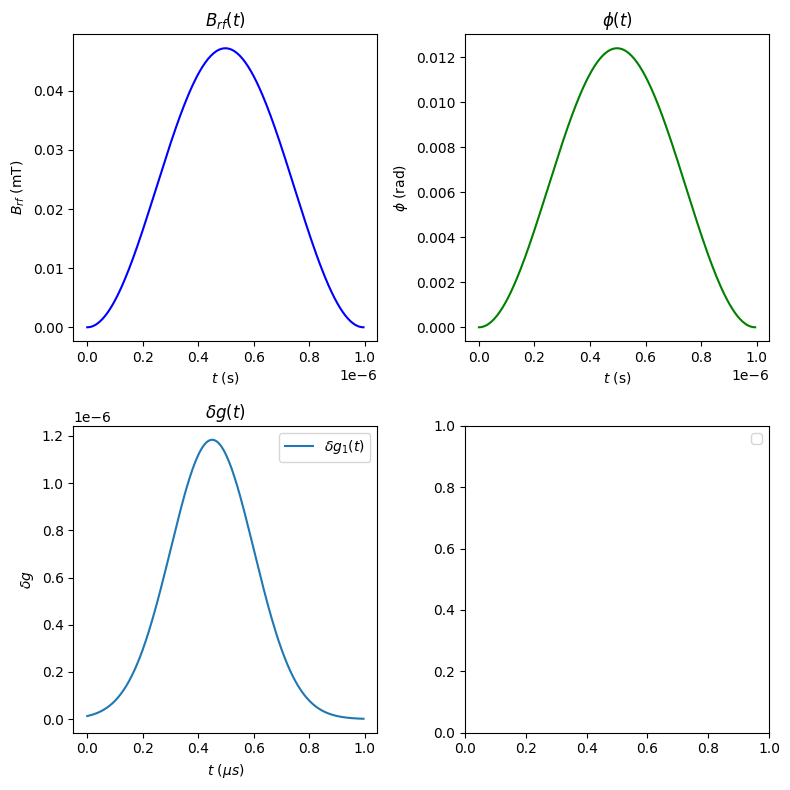

In [763]:

# Create a 2x1 figure
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# First subplot
axs[0][0].plot(t_units, B_rf.cpu().detach().numpy()/1e-3, 'b')
axs[0][0].set_title("$B_{rf}(t)$")
axs[0][0].set_ylabel("$B_{rf}$ (mT)")
axs[0][0].set_xlabel("$t$ (s)")

# Second subplot
axs[0][1].plot(t_units, phi.cpu().detach().numpy(), 'g')
axs[0][1].set_title("$\phi(t)$")
axs[0][1].set_ylabel("$\phi$ (rad)")
axs[0][1].set_xlabel("$t$ (s)")

# Plot g
for i in range(len(V)):
    axs[1,0].plot(1e6 * t_units, g(V[i]).detach().numpy(), label=f"$\delta g_{i+1}(t)$")
axs[1,0].set_title(r"$\delta g(t)$")
axs[1,0].set_xlabel(r'$t\ (\mu s)$')
axs[1,0].set_ylabel(r"$\delta g$")
axs[1,0].legend()

if N >= 2:
    # Plot J
    for i in range(len(W)):
        axs[1, 1].plot(t_units, J(W[i]).detach().numpy()/((6.242e-18) * 1e-6),label= r"$J_{{{}{}}}(t)$".format(i+1, i+2))
    axs[1, 1].set_title(r"$J(t)$")
    axs[1, 1].set_xlabel(r'$t\ (\mu s)$')
    axs[1, 1].set_ylabel(r"$J$ ($\mu$ eV)")
axs[1, 1].legend()

# Adjust spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

## Construct Hamiltonian w/ Optimization Variables

In [764]:
def construct_superop(V, B_rf, phi, W, L, N, dispersive=False):

    H = 0.5 * ((1 + g(V).view(N, -1, 1, 1)/2) * w - w_rf) * Z_precalc \
          + 0.5 * (2 * muB / hbar) * B_rf.view(-1, 1, 1).unsqueeze(0).repeat(N,1,1,1) * \
              (torch.cos(phi).view(-1, 1, 1).unsqueeze(0).repeat(N,1,1,1) * X_precalc + torch.sin(phi).view(-1, 1, 1).unsqueeze(0).repeat(N,1,1,1) * Y_precalc)

    if N >= 2:
        H_exchange = (J(W).view(-1,1,1).unsqueeze(0).repeat(N-1,1,1,1) / (4 * hbar)) * sigma_squared_precalc

    H_tot = torch.sum(torch.cat([H,H_exchange]) if N >= 2 else H, dim=0)

    L = -1j * (batch_kron(H_tot, torch.eye(2**N).repeat(M,1,1)) - batch_kron(torch.eye(2**N).repeat(M,1,1), H_tot.transpose(1,2))) + int(dispersive) * Gamma
    exp_L = torch.matrix_exp(L * dt)
    L = torch.linalg.multi_dot([*exp_L])

    return L

t0 = time.time()
L_F = construct_superop(V, B_rf, phi, W, L, N, isDispersive)
print("Time to create superoperator: ", time.time() - t0)



Time to create superoperator:  0.004961967468261719


In [765]:
def evolve_rho(rho0, V, B_rf, phi, W, L, N, dispersive=False):

    H = 0.5 * ((1 + g(V).view(N, -1, 1, 1)/2) * w - w_rf) * Z_precalc \
          + 0.5 * (2 * muB / hbar) * B_rf.view(-1, 1, 1).unsqueeze(0).repeat(N,1,1,1) * \
              (torch.cos(phi).view(-1, 1, 1).unsqueeze(0).repeat(N,1,1,1) * X_precalc + torch.sin(phi).view(-1, 1, 1).unsqueeze(0).repeat(N,1,1,1) * Y_precalc)

    if N >= 2:
        H_exchange = (J(W).view(-1,1,1).unsqueeze(0).repeat(N-1,1,1,1) / (4 * hbar)) * sigma_squared_precalc

    H_tot = torch.sum(torch.cat([H,H_exchange]) if N >= 2 else H, dim=0)

    L = -1j * (batch_kron(H_tot, torch.eye(2**N).repeat(M,1,1)) - batch_kron(torch.eye(2**N).repeat(M,1,1), H_tot.transpose(1,2))) + int(dispersive) * Gamma
    exp_L = torch.matrix_exp(L * dt)

    rhos = torch.zeros((M, 2, 2), dtype=tensor_imag_dtype)

    def custom_cumprod(tensor):
        result = []
        product = tensor[0]
        result.append(product)

        for i in range(1, tensor.shape[0]):
            product = torch.mm(product, tensor[i])
            result.append(product)

        return torch.stack(result)

    cumprod_exp_L = custom_cumprod(exp_L)

    rho0_extended = rho0.view(-1,).repeat(M,1,1).transpose(1,2)

    rhos = torch.bmm(cumprod_exp_L, rho0_extended).view(-1,2**N,2**N)
    return rhos

## Construct State and Unitary

In [766]:
theta_state = np.pi
phi_state = 0

state_vector = [np.cos(theta_state/2), np.sin(theta_state/2) * np.exp(1j * phi_state)]
state_vector = normalize_state(torch.tensor(state_vector, dtype=tensor_imag_dtype))

# state_vector = [0, 1, 0, 0]
# state_vector = normalize_state(torch.tensor(state_vector, dtype=tensor_imag_dtype))

rho0 = torch.outer(state_vector.conj(), state_vector)
print(rho0)

tensor([[3.7494e-33+0.j, 6.1232e-17+0.j],
        [6.1232e-17+0.j, 1.0000e+00+0.j]])


In [767]:
import qiskit.circuit.library as unitary
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit import execute 

#Changing the simulator 
backend = Aer.get_backend('unitary_simulator')
circ = QuantumCircuit(N)

circ.append(unitary.RXGate(theta=np.pi), [0])
# circ.append(unitary.SwapGate(), [0,1])

job = execute(circ, backend)
result = job.result()

#get the unitary matrix from the result object
U = result.get_unitary(circ, decimals=4)

U = torch.from_numpy(U.to_matrix()).type(tensor_imag_dtype)

L_desired = torch.kron(U.conj(), U)
rho_desired = torch.matmul(L_desired, rho0.view(-1,))
print(rho_desired)

tensor([1.0000e+00+0.j, 6.1232e-17+0.j, 6.1232e-17+0.j, 3.7494e-33+0.j])


## PyTorch Optimization

In [774]:
class CostFunction(nn.Module):
    def __init__(self):
        super(CostFunction, self).__init__()

    def fidelity(self, output, target):
        fid = torch.abs(torch.trace(
            torch.mm(
                hermitian_conj(output), target
            )
        )) / (2**(2*N))

        return fid
    
    def forward(self, output, target):

        fid = self.fidelity(output,target)

        operator_dist = nn.L1Loss()
        p = 1
        return p * (fid-1)**2 + (1-p) * operator_dist(output, target), fid

lr_dict = {'V': 1e-1, 'B_rf': 1e-1, 'phi':1e-1, 'W': 1e-2}
opt_params = [
            {'params': V_coeffs, 'lr': lr_dict['V']},
            {'params': B_rf_coeffs, 'lr': lr_dict['B_rf']},
            {'params': phi_coeffs, 'lr': lr_dict['phi'],},
            {'params': W_coeffs, 'lr': lr_dict['W']},
        ]

optimizer = torch.optim.Adam(opt_params)

criterion = CostFunction()

epochs = 5000
loss_array = []

fid_threshold = 0.9995

for i in range(epochs):

    optimizer.zero_grad()

    # Calculate L
    B_rf = fourier_series(B_rf_scale, t_units_tensor, B_rf_coeffs)
    phi = fourier_series(1, t_units_tensor, phi_coeffs)    

    W = build_W(t_units_tensor, W_sigma * dt, W_skip, torch.abs(W_coeffs))
    if len(W) == 0:
        pass
    elif len(W) == 1:
        W = W[0]
    else:
        W = torch.cat(W, dim=0)

    V = build_V(t_units_tensor, V_sigma * dt, V_skip, torch.abs(V_coeffs))
    if len(V) == 0:
        pass
    elif len(V) == 1:
        V = V[0]
    else:
        V = torch.cat(V, dim=0)

    L = construct_superop(V, B_rf, phi, W, L, N, dispersive=isDispersive)
    
    loss, fid = criterion(L, L_desired)

    loss.backward()
    optimizer.step()

    loss_array.append(loss.item())

    if i % 100 == 0:
        print("Step {}: Loss = {}, Fidelity = {}".format(i, loss.item(), fid))

    if fid > fid_threshold and fid < 1:
        break


Step 0: Loss = 6.298061634879559e-06, Fidelity = 0.997490406036377
Step 100: Loss = 4.060683750140015e-06, Fidelity = 0.9979848861694336
Step 200: Loss = 2.8318761451373575e-06, Fidelity = 0.9983171820640564
Step 300: Loss = 1.9231079022574704e-06, Fidelity = 0.9986132383346558
Step 400: Loss = 1.3124022189003881e-06, Fidelity = 0.998854398727417
Step 500: Loss = 9.319138030150498e-07, Fidelity = 0.9990346431732178
Step 600: Loss = 6.906732892275613e-07, Fidelity = 0.9991689324378967
Step 700: Loss = 5.249785886007885e-07, Fidelity = 0.9992754459381104
Step 800: Loss = 4.0735864104135544e-07, Fidelity = 0.9993617534637451
Step 900: Loss = 3.280322857790452e-07, Fidelity = 0.9994272589683533
Step 1000: Loss = 2.6471775527170394e-07, Fidelity = 0.9994854927062988


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


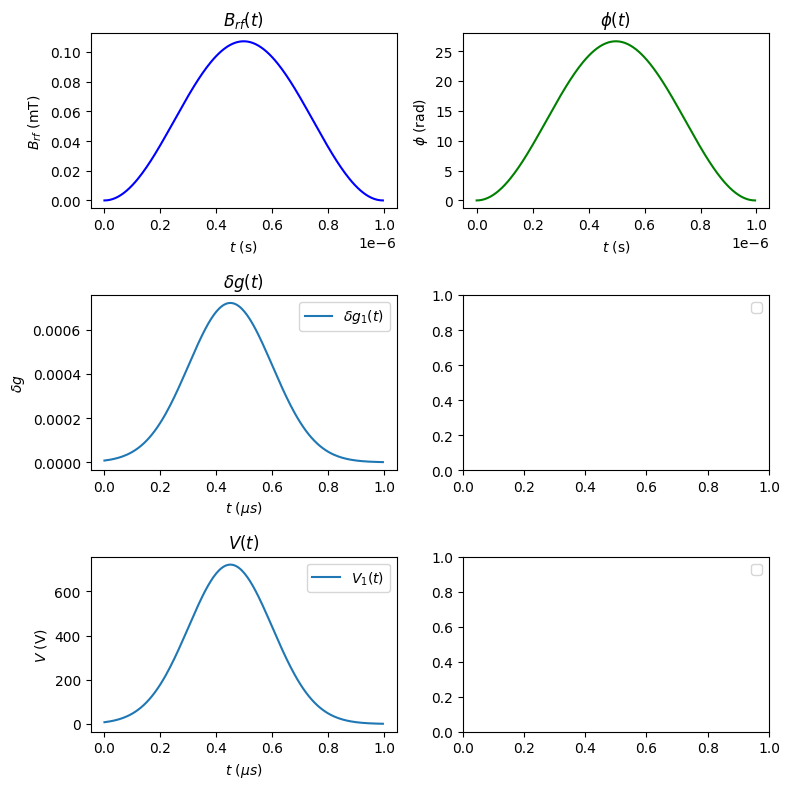

In [775]:

# Create a 2x1 figure
fig, axs = plt.subplots(3, 2, figsize=(8, 8))

# First subplot
axs[0][0].plot(t_units, B_rf.cpu().detach().numpy()/1e-3, 'b')
axs[0][0].set_title("$B_{rf}(t)$")
axs[0][0].set_ylabel("$B_{rf}$ (mT)")
axs[0][0].set_xlabel("$t$ (s)")

# Second subplot
axs[0][1].plot(t_units, phi.cpu().detach().numpy(), 'g')
axs[0][1].set_title("$\phi(t)$")
axs[0][1].set_ylabel("$\phi$ (rad)")
axs[0][1].set_xlabel("$t$ (s)")

# Plot g
for i in range(len(V)):
    axs[1,0].plot(1e6 * t_units, g(V[i]).detach().numpy(), label=f"$\delta g_{i+1}(t)$")
axs[1,0].set_title(r"$\delta g(t)$")
axs[1,0].set_xlabel(r'$t\ (\mu s)$')
axs[1,0].set_ylabel(r"$\delta g$")
axs[1,0].legend()

if N >= 2:
    # Plot J
    for i in range(len(W)):
        axs[1, 1].plot(t_units, J(W[i]).detach().numpy()/((6.242e-18) * 1e-6),label= r"$J_{{{}{}}}(t)$".format(i+1, i+2))
    axs[1, 1].set_title(r"$J(t)$")
    axs[1, 1].set_xlabel(r'$t\ (\mu s)$')
    axs[1, 1].set_ylabel(r"$J$ ($\mu$ eV)")
axs[1, 1].legend()

# Plot g
for i in range(len(V)):
    axs[2,0].plot(1e6 * t_units, V[i].detach().numpy(), label=f"$V_{i+1}(t)$")
axs[2,0].set_title(r"$V(t)$")
axs[2,0].set_xlabel(r'$t\ (\mu s)$')
axs[2,0].set_ylabel(r"$V$ (V)")
axs[2,0].legend()

if N >= 2:
    # Plot J
    for i in range(len(W)):
        axs[2,1].plot(t_units,W[i].detach().numpy(),label= r"$W_{{{}{}}}(t)$".format(i+1, i+2))
    axs[2,1].set_title(r"$W(t)$")
    axs[2,1].set_xlabel(r'$t\ (\mu s)$')
    axs[2,1].set_ylabel(r"$W$ (V)")
axs[2,1].legend()

# Adjust spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

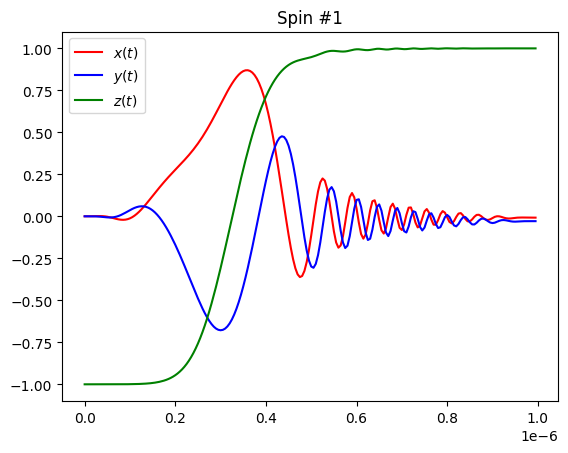

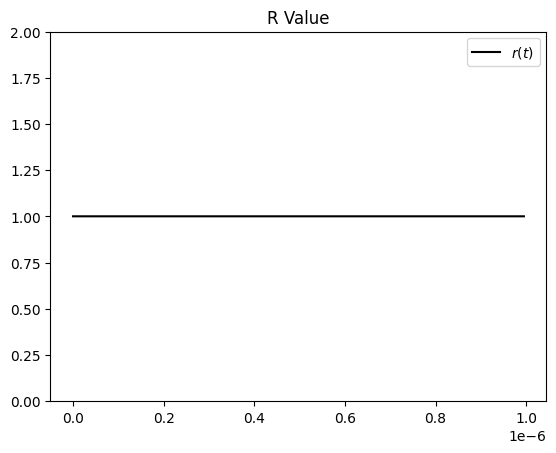

Starting: [1.0953507804325961e-16, -5.476791952471158e-17, -1.0] 

Ending: [-0.007981160655617714, -0.0289109218865633, 0.99952632188797]


In [776]:
for i in range(1,N+1):
    bloch_animation(i, evolve_rho(rho0, V, B_rf, phi, W, L, N, dispersive=isDispersive).detach().numpy(), rho_desired.view(2**N, 2**N), plot=True, bloch_sphere=True)

In [777]:
print("Final Unitary Fidelity: ",fid.item())

rho_out = torch.matmul(
            L, rho0.view(-1,)
        )

print("Rho fidelity: ", fidelity_states(rho_out.view(2**N, 2**N),rho_desired.view(2**N, 2**N)).item())


Final Unitary Fidelity:  0.9995004534721375
Rho fidelity:  0.9997498393058777


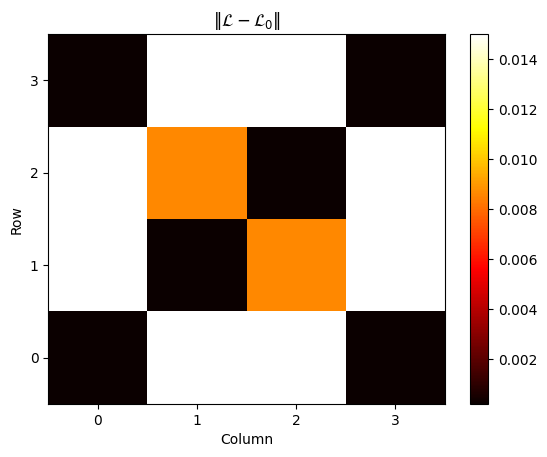

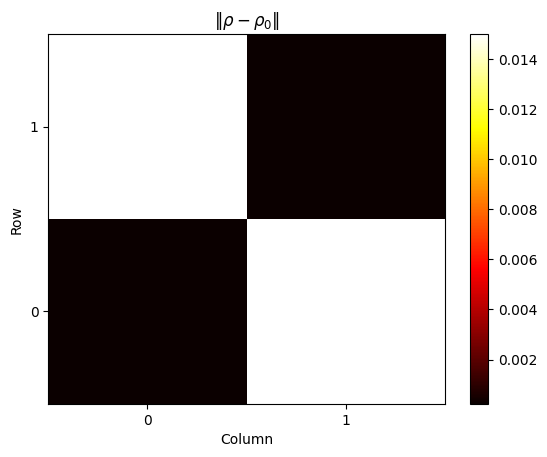

In [778]:
plot_tensor_difference(L.detach().numpy(), L_desired.detach().numpy(), title=r"$\Vert \mathcal{L} - \mathcal{L}_0\Vert $")
plot_tensor_difference(rho_out.view(2**N, 2**N).detach().numpy(), rho_desired.view(2**N, 2**N).detach().numpy(), title=r"$\Vert \rho  - \rho_0 \Vert$")
